In [1]:
import torch
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class SignalClassifier(nn.Module):
    def __init__(self, input_channels, filter_size, win_len):
        super(SignalClassifier, self).__init__()

        # Initial convolution layer with increased filters
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=2, kernel_size=filter_size, padding='same')
        self.bn1 = nn.BatchNorm1d(2)  # BatchNorm layer after the first conv layer
        self.prelu1 = nn.PReLU()

        # Branch 1: Convolution layers followed by output layer
        self.branch1_layers = nn.ModuleList()
        self.branch1_bns = nn.ModuleList()  # BatchNorm layers for branch 1
        for i in range(2):
            self.branch1_layers.append(nn.Conv1d(in_channels=2 if i == 0 else 8, out_channels=8, kernel_size=filter_size, padding='same'))
            self.branch1_bns.append(nn.BatchNorm1d(8))
        self.branch1_prelus = nn.ModuleList([nn.PReLU() for _ in range(2)])
        self.out_branch1 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=filter_size, padding='same')
        
        self.fc1_branch1 = nn.Linear(8*win_len, 128)
        self.fc2_branch1 = nn.Linear(128, 1)
        
        # Branch 2: Convolution layers followed by output layer
        self.branch2_layers = nn.ModuleList()
        self.branch2_bns = nn.ModuleList()  # BatchNorm layers for branch 2
        for i in range(2):
            self.branch2_layers.append(nn.Conv1d(in_channels=2 if i == 0 else 8, out_channels=8, kernel_size=filter_size, padding='same'))
            self.branch2_bns.append(nn.BatchNorm1d(8))
        self.branch2_prelus = nn.ModuleList([nn.PReLU() for _ in range(2)])
        self.out_branch2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=filter_size, padding='same')
        
        self.fc1_branch2 = nn.Linear(8*win_len, 128)
        self.fc2_branch2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.prelu1(self.bn1(self.conv1(x)))  # Apply BatchNorm after the first conv layer

        # Branch 1
        x_branch1 = x
        for layer, bn, prelu in zip(self.branch1_layers, self.branch1_bns, self.branch1_prelus):
            x_branch1 = prelu(bn(layer(x_branch1)))  # Apply BatchNorm after each conv layer
        x_branch1 = self.out_branch1(x_branch1)
        x_branch1 = x_branch1.view(x_branch1.size(0), -1)  # Flatten the output
        x_branch1 = F.relu(self.fc1_branch1(x_branch1))
        out1 = self.fc2_branch1(x_branch1)

        # Branch 2
        x_branch2 = x
        for layer, bn, prelu in zip(self.branch2_layers, self.branch2_bns, self.branch2_prelus):
            x_branch2 = prelu(bn(layer(x_branch2)))  # Apply BatchNorm after each conv layer
        x_branch2 = self.out_branch2(x_branch2)
        x_branch2 = x_branch2.view(x_branch2.size(0), -1)  # Flatten the output
        x_branch2 = F.relu(self.fc1_branch2(x_branch2))
        out2 = self.fc2_branch2(x_branch2)

        return out1, out2
    
class SignalClassifierSeq(nn.Module):
    def __init__(self, input_channels, filter_size, win_len):
        super(SignalClassifierSeq, self).__init__()

        # Initial convolution layer
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=2, kernel_size=filter_size, padding='same')
        self.bn1 = nn.BatchNorm1d(2)  # BatchNorm layer after the first conv layer
        self.prelu1 = nn.PReLU()

        # Convolution layers followed by output layer
        self.branch1_layers = nn.ModuleList()
        self.branch1_bns = nn.ModuleList()  # BatchNorm layers for branch 1
        for i in range(2):
            self.branch1_layers.append(nn.Conv1d(in_channels=2 if i == 0 else 8, out_channels=8, kernel_size=filter_size, padding='same'))
            self.branch1_bns.append(nn.BatchNorm1d(8))
        self.branch1_prelus = nn.ModuleList([nn.PReLU() for _ in range(2)])
        self.out_branch1 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=filter_size, padding='same')
        
        self.fc1_branch1 = nn.Linear(8*win_len, 128)
        self.fc2_branch1 = nn.Linear(128, 1)
        

    def forward(self, x):
        x_branch1 = self.prelu1(self.bn1(self.conv1(x)))  # Apply BatchNorm after the first conv layer

        for layer, bn, prelu in zip(self.branch1_layers, self.branch1_bns, self.branch1_prelus):
            x_branch1 = prelu(bn(layer(x_branch1)))  # Apply BatchNorm after each conv layer
        x_branch1 = self.out_branch1(x_branch1)
        x_branch1 = x_branch1.view(x_branch1.size(0), -1)  # Flatten the output
        x_branch1 = F.relu(self.fc1_branch1(x_branch1))
        out1 = self.fc2_branch1(x_branch1)

        return out1



In [2]:
# Load the data
test_database_sim = torch.load('./Data/test_classification_short_TEST')
test_database_seq = torch.load('./Data/test_classification_short_seq_TEST')


In [3]:
test_names_sim = test_database_sim['file_names']
test_names_seq = test_database_seq['file_names']


test_modes_sim = test_database_sim['mode_descriptions']
test_modes_seq = test_database_seq['mode_descriptions']

In [4]:
test_modes_sim[0], test_modes_seq[0]

(('Conduction 4', 'Conduction 4'), ('Conduction 4', 'Conduction 4'))

In [5]:
def mode_to_int(mode):
    return 0 if 'Conduction' in mode else 1

test_modes_int_sim = [(mode_to_int(mode0), mode_to_int(mode1)) for mode0, mode1 in test_modes_sim]
test_modes_int_seq = [(mode_to_int(mode0), mode_to_int(mode1)) for mode0, mode1 in test_modes_seq]


In [6]:
test_data_sim = test_database_sim['sim_tensor']
test_data_seq = test_database_seq['seq_tensor']

In [7]:
test_data_sim.shape, test_data_seq.shape

(torch.Size([4740, 3, 5000]), torch.Size([4740, 2, 3, 5000]))

In [8]:
import numpy as np
# Set random seed for reproducibility
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)


In [9]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, data, modes, names):
        """
        Args:
            data (Tensor): A tensor containing the data.
            modes (list): A list of mode descriptions for each sample.
            names (list): A list of file names for each sample.
        """
        self.data = data
        self.modes = modes
        self.names = names

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        mode = self.modes[idx]
        name = self.names[idx]
        return sample, mode, name


In [10]:
# Params that do not change
input_channels = 3  
win_len = test_data_sim.shape[-1]  

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [12]:
# Define the loss function
loss_function = nn.BCEWithLogitsLoss()


In [13]:
import pandas as pd
import torch
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix_with_percentages(targets, preds, title, target_names=['Negative', 'Positive']):
    cm = confusion_matrix(targets.numpy(), preds.numpy())
    # Normalise
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(cmn*100, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names, ax=ax)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.show(block=False)

def evaluate_model(model, device, test_loader, loss_function, eval_type):
    model.eval()
    total_loss = 0
    all_targets, all_preds = [], []
    
    with torch.no_grad():
        for data, (target1, target2), _ in test_loader:
            data = data.to(device)
            target1, target2 = target1.to(device).float(), target2.to(device).float()
            
            if eval_type == "sim":
                outputs = model(data)
            elif eval_type == "seq":
                data1, data2 = data[:, 0, :, :], data[:, 1, :, :]
                output1 = model(data1)
                output2 = model(data2)
                outputs = (output1, output2)
            else:
                raise ValueError("Invalid eval_type specified")
            
            for i, output in enumerate(outputs):
                target = target1 if i == 0 else target2
                loss = loss_function(output.squeeze(), target)
                total_loss += loss.item()
                
                sig_output = torch.sigmoid(output).squeeze()
                pred = sig_output > 0.5
                
                all_targets.append(target.cpu())
                all_preds.append(pred.float().cpu())

    all_targets = torch.cat(all_targets)
    all_preds = torch.cat(all_preds)
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(all_targets, all_preds, average='binary')
    accuracy = all_preds.eq(all_targets.view_as(all_preds)).sum().item() / len(all_targets)
    
    metrics_df = pd.DataFrame({
        'Precision': [precision*100],
        'Recall': [recall*100],
        'F1 Score': [f1_score*100],
        'Accuracy': [accuracy*100]
    })
    
    # Print metrics
    display(metrics_df.style.hide(axis='index'))
    
    # Plot confusion matrix with percentages
    plot_confusion_matrix_with_percentages(all_targets, all_preds, f"Predictions ({eval_type})", ['Negative', 'Positive'])
    
    return metrics_df


In [14]:
model_sim_paths = ['./best_model.pth', 
                   './best_model_no_resonant.pth', 
                   './best_model_only_front.pth', 
                   './best_model_only_rear.pth', 
                   './best_model_only_resonant.pth']
model_seq_paths = ['./best_model_seq.pth', 
                   './best_model_seq_no_resonant.pth', 
                   './best_model_seq_only_front.pth', 
                   './best_model_seq_only_rear.pth', 
                   './best_model_seq_only_resonant.pth']

In [15]:
test_data_sim.shape, test_data_seq.shape

(torch.Size([4740, 3, 5000]), torch.Size([4740, 2, 3, 5000]))

Evaluating: All Sensors


Precision,Recall,F1 Score,Accuracy
59.008556,49.472574,53.821437,57.552743


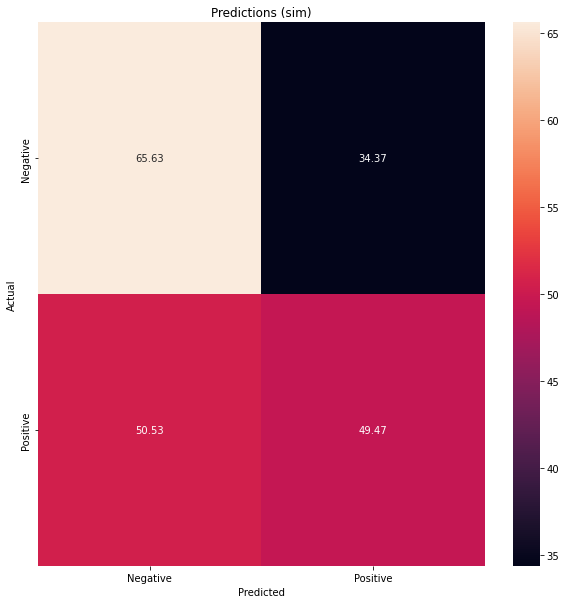

Precision,Recall,F1 Score,Accuracy
99.484425,97.700422,98.584353,98.597046


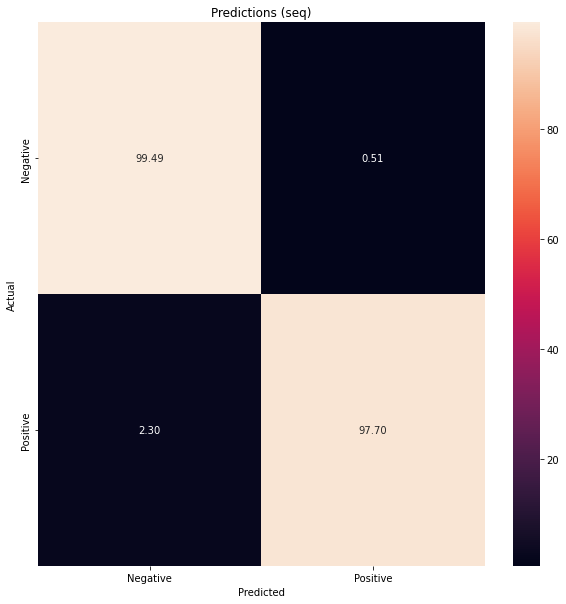

Evaluating: No Resonant


Precision,Recall,F1 Score,Accuracy
92.783928,95.485232,94.115201,94.029536


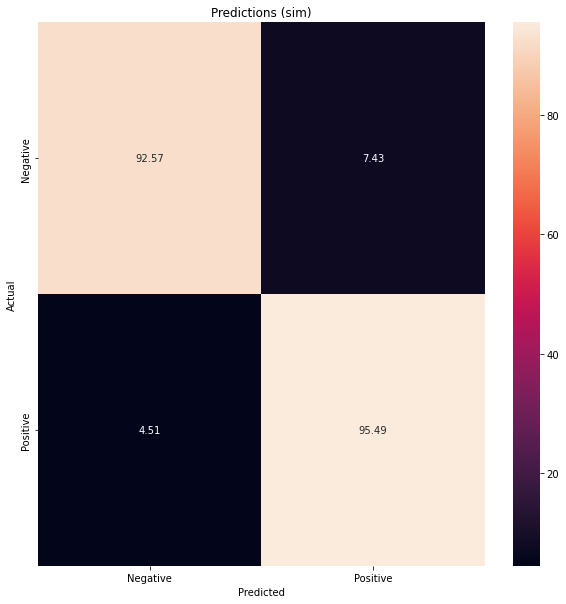

Precision,Recall,F1 Score,Accuracy
98.737108,98.966245,98.851544,98.850211


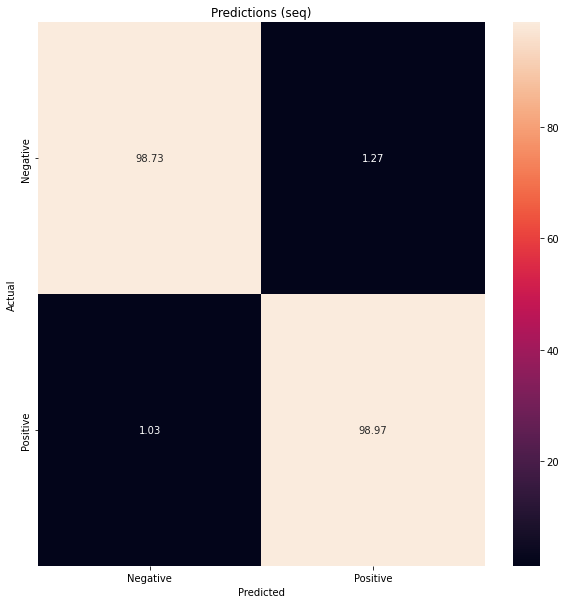

Evaluating: Only Front


Precision,Recall,F1 Score,Accuracy
92.615160,80.168776,85.943684,86.888186


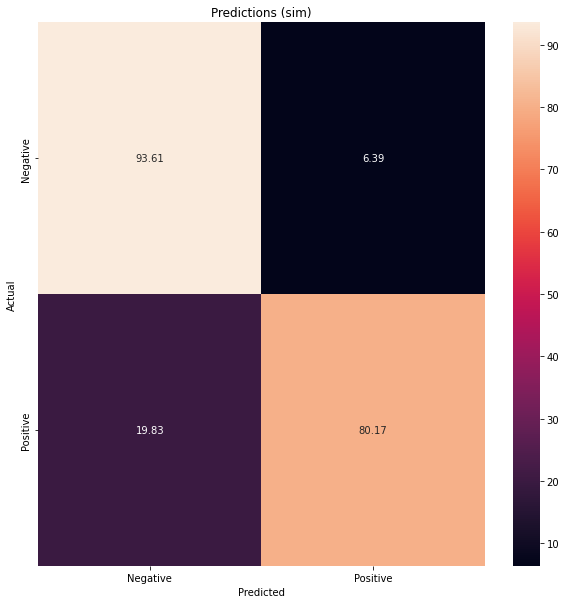

Precision,Recall,F1 Score,Accuracy
99.915128,99.345992,99.629747,99.630802


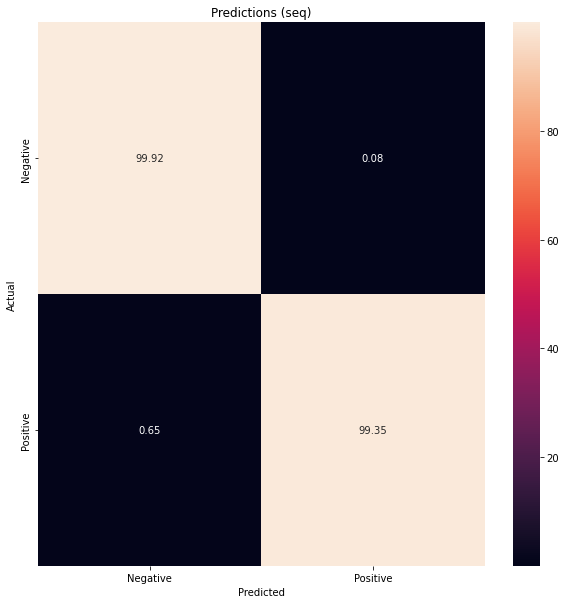

Evaluating: Only Rear


Precision,Recall,F1 Score,Accuracy
94.799748,95.379747,95.088863,95.073840


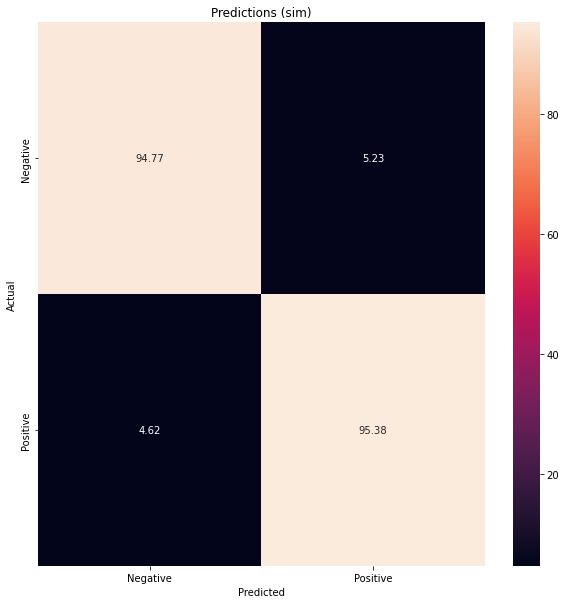

Precision,Recall,F1 Score,Accuracy
96.031079,96.476793,96.253420,96.244726


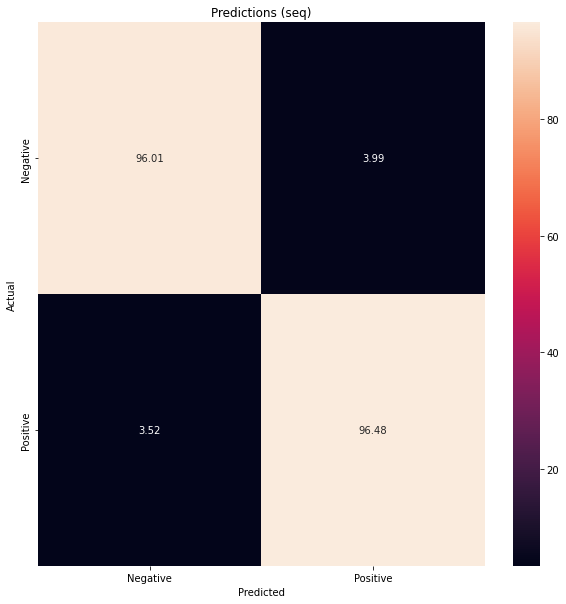

Evaluating: Only Resonant


Precision,Recall,F1 Score,Accuracy
50.501253,51.012658,50.755668,50.506329


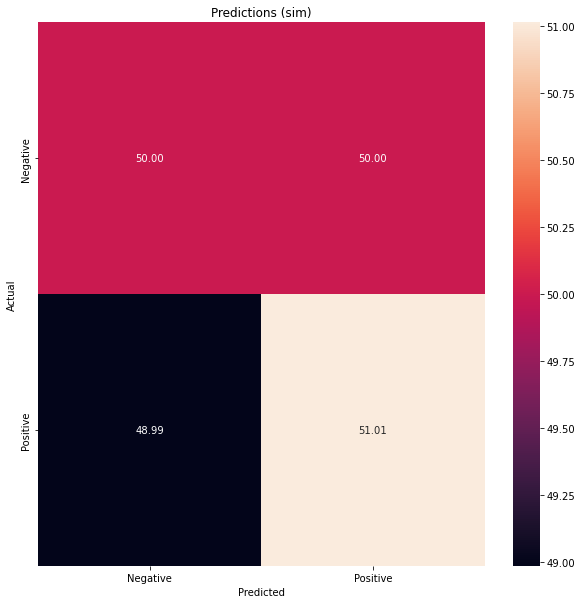

Precision,Recall,F1 Score,Accuracy
51.443456,100.000000,67.937509,52.805907


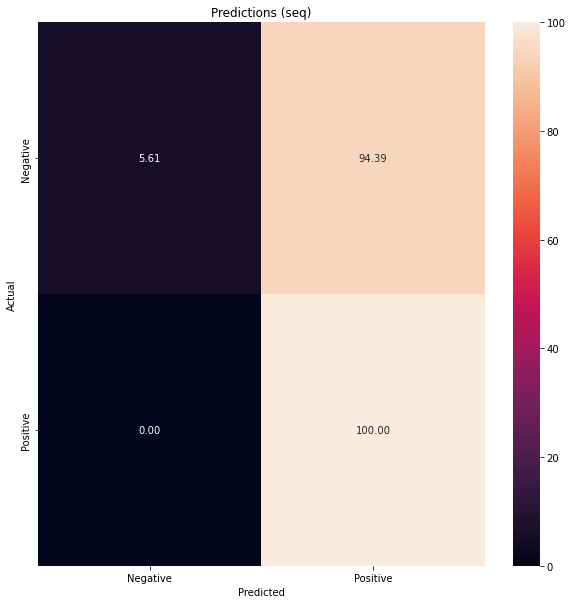

Configuration,Accuracy,Precision,Recall,F1-Score,Performance Reduction (%)
All Sensors,57.55 (98.60),59.01 (99.48),49.47 (97.70),53.82 (98.58),45.41
No Resonant,94.03 (98.85),92.78 (98.74),95.49 (98.97),94.12 (98.85),4.79
Only Front,86.89 (99.63),92.62 (99.92),80.17 (99.35),85.94 (99.63),13.74
Only Rear,95.07 (96.24),94.80 (96.03),95.38 (96.48),95.09 (96.25),1.21
Only Resonant,50.51 (52.81),50.50 (51.44),51.01 (100.00),50.76 (67.94),25.29


In [16]:
all_metrics = []  # Initialize an empty list to collect metrics

# Loop through pairs of model paths for simultaneous and sequential models
for model_sim_path, model_seq_path in zip(model_sim_paths, model_seq_paths):
    try:
        # Attempt to load the saved model state dicts
        model_sim_data = torch.load(model_sim_path)
        model_seq_data = torch.load(model_seq_path)
    except FileNotFoundError as e:
        # If model files are not found, report the error and skip to the next iteration
        print(f"Error loading models: {e}. Skipping...")
        continue
    
    # Adjust the test data based on the model type indicated by the file name
    # This allows for testing different model configurations
    configuration = "All Sensors"
    if 'no_resonant' in model_sim_path:
        configuration = "No Resonant"
        # Narrow down the channels to exclude resonant data if specified
        test_data_sim_a = test_data_sim.narrow(1, 0, 2)
        test_data_seq_a = test_data_seq.narrow(2, 0, 2)
    elif 'only_front' in model_sim_path:
        configuration = "Only Front"
        # Narrow down to only front sensor data if specified
        test_data_sim_a = test_data_sim.narrow(1, 0, 1)
        test_data_seq_a = test_data_seq.narrow(2, 0, 1)   
    elif 'only_rear' in model_sim_path:
        configuration = "Only Rear"
        # Narrow down to only rear sensor data if specified
        test_data_sim_a = test_data_sim.narrow(1, 1, 1)
        test_data_seq_a = test_data_seq.narrow(2, 1, 1) 
    elif 'only_resonant' in model_sim_path:
        configuration = "Only Resonant"
        # Narrow down to only resonant data if specified
        test_data_sim_a = test_data_sim.narrow(1, 2, 1)
        test_data_seq_a = test_data_seq.narrow(2, 2, 1)    
    else: 
        # Use the full dataset if no specific configuration is specified
        test_data_sim_a = test_data_sim
        test_data_seq_a = test_data_seq
    print(f"Evaluating: {configuration}")
        
    # Create dataset instances with the adjusted data
    test_dataset_sim = CustomDataset(test_data_sim_a, test_modes_int_sim, test_names_sim)
    test_dataset_seq = CustomDataset(test_data_seq_a, test_modes_int_seq, test_names_seq)

    # Define batch size for data loading
    batch_size = 64
    # Create DataLoader instances for batched data processing
    test_loader_sim = DataLoader(test_dataset_sim, batch_size=batch_size, shuffle=False)
    test_loader_seq = DataLoader(test_dataset_seq, batch_size=batch_size, shuffle=False)
    
    # Extract the filter size used in the best models from the saved state dicts
    best_filter_size_sim = model_sim_data['conv1.weight'].shape[-1]
    best_filter_size_seq = model_seq_data['conv1.weight'].shape[-1]

    # Initialize the models with the determined best filter size and other relevant configurations
    model_sim = SignalClassifier(input_channels=test_data_sim_a.shape[1], filter_size=best_filter_size_sim, win_len=win_len).to(device)
    model_seq = SignalClassifierSeq(input_channels=test_data_seq_a.shape[2], filter_size=best_filter_size_seq, win_len=win_len).to(device)

    # Load the saved state dicts into the respective models
    model_sim.load_state_dict(model_sim_data)
    model_seq.load_state_dict(model_seq_data)

    # Set the models to evaluation mode
    model_sim.eval()
    model_seq.eval()

    # Evaluate the models using the created DataLoader instances and custom evaluation function
    metrics_sim = evaluate_model(model_sim, device, test_loader_sim, loss_function, eval_type="sim")
    metrics_seq = evaluate_model(model_seq, device, test_loader_seq, loss_function, eval_type="seq")

    # Compile metrics for DataFrame
    f1_score_sim = metrics_sim['F1 Score'][0]  
    f1_score_seq = metrics_seq['F1 Score'][0] 
    performance_reduction = (f1_score_seq - f1_score_sim)/f1_score_seq * 100 # Calculate the performance reduction

    row = {
        "Configuration": configuration,
        "Accuracy": f"{metrics_sim['Accuracy'][0]:.2f} ({metrics_seq['Accuracy'][0]:.2f})",
        "Precision": f"{metrics_sim['Precision'][0]:.2f} ({metrics_seq['Precision'][0]:.2f})",
        "Recall": f"{metrics_sim['Recall'][0]:.2f} ({metrics_seq['Recall'][0]:.2f})",
        "F1-Score": f"{f1_score_sim:.2f} ({f1_score_seq:.2f})",
        "Performance Reduction (%)": f"{performance_reduction:.2f}"  # Add performance reduction to the row
    }
    all_metrics.append(row)

    
    torch.cuda.empty_cache()  # Clear memory between iterations

# Convert collected metrics to DataFrame and display
metrics_df = pd.DataFrame(all_metrics)
display(metrics_df.style.hide(axis='index'))


In [17]:
display(metrics_df.style.hide(axis='index'))


Configuration,Accuracy,Precision,Recall,F1-Score,Performance Reduction (%)
All Sensors,57.55 (98.60),59.01 (99.48),49.47 (97.70),53.82 (98.58),45.41
No Resonant,94.03 (98.85),92.78 (98.74),95.49 (98.97),94.12 (98.85),4.79
Only Front,86.89 (99.63),92.62 (99.92),80.17 (99.35),85.94 (99.63),13.74
Only Rear,95.07 (96.24),94.80 (96.03),95.38 (96.48),95.09 (96.25),1.21
Only Resonant,50.51 (52.81),50.50 (51.44),51.01 (100.00),50.76 (67.94),25.29
